In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Data Importing

In [3]:
path_train = '/content/drive/MyDrive/garbage-classification-project/one-indexed-files-notrash_train.txt'
path_test = '/content/drive/MyDrive/garbage-classification-project/one-indexed-files-notrash_test.txt'
path_val = '/content/drive/MyDrive/garbage-classification-project/one-indexed-files-notrash_val.txt'

df_train = pd.read_csv(path_train, sep = ' ', header = None, names = ['path', 'label'] )
df_val = pd.read_csv(path_val, sep = ' ', header = None, names = ['path', 'label'] )
df_test = pd.read_csv(path_test, sep = ' ', header = None, names = ['path', 'label'] )

In [4]:
df_train

,path,label
0,cardboard202.jpg,3
1,paper472.jpg,2
2,paper522.jpg,2
3,glass189.jpg,1
4,glass325.jpg,1
...,...,...
1763,cardboard6.jpg,3
1764,glass283.jpg,1
1765,metal335.jpg,5
1766,plastic133.jpg,4


In [5]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

df_train = add_class_name_prefix (df_train, 'path')
df_val = add_class_name_prefix (df_val, 'path')
df_test = add_class_name_prefix (df_test, 'path')

In [6]:
def num_to_label(df, col_name):
    label_dic = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    df[col_name] = df[col_name].apply(lambda x: label_dic[x])
    return df

df_train = num_to_label (df_train, 'label')
df_val = num_to_label (df_val, 'label')
df_test = num_to_label (df_test, 'label')

In [7]:
df_train

,path,label
0,cardboard/cardboard202.jpg,cardboard
1,paper/paper472.jpg,paper
2,paper/paper522.jpg,paper
3,glass/glass189.jpg,glass
4,glass/glass325.jpg,glass
...,...,...
1763,cardboard/cardboard6.jpg,cardboard
1764,glass/glass283.jpg,glass
1765,metal/metal335.jpg,metal
1766,plastic/plastic133.jpg,plastic


In [8]:
IMG_dir = '/content/drive/MyDrive/garbage-classification-project/Garbage classification/Garbage classification'

### Preprocessing of Images (Creating a Generator for Train, Validation, and Test Sets)

In [9]:
generator = ImageDataGenerator(rescale = 1./255)

img_gen_train = generator.flow_from_dataframe(df_train,
                                              directory = IMG_dir,
                                              x_col = 'path',
                                              y_col = 'label',
                                              color = 'rgb',
                                              class_mode = 'categorical',
                                              batch_size = 32,
                                              shuffle = True
                                              )

Found 1768 validated image filenames belonging to 6 classes.


In [10]:
img_gen_val = generator.flow_from_dataframe(df_val,
                                              directory = IMG_dir,
                                              x_col = 'path',
                                              y_col = 'label',
                                              color = 'rgb',
                                              class_mode = 'categorical',
                                              batch_size = 32,
                                              shuffle = True
                                              )

Found 328 validated image filenames belonging to 6 classes.


In [11]:
img_gen_test = generator.flow_from_dataframe(df_test,
                                              directory = IMG_dir,
                                              x_col = 'path',
                                              y_col = 'label',
                                              color = 'rgb',
                                              class_mode = 'categorical',
                                              batch_size = 32,
                                              shuffle = False
                                              )

Found 431 validated image filenames belonging to 6 classes.


### Loading the Pre-trained VGG16 Model

In [12]:
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
pretrained_model.trainable = False

### Creating Model

In [14]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dense(6, activation = 'softmax'))

### Model Compilation

In [15]:
model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',
              metrics = [tf.keras.metrics.categorical_accuracy])

### Training Model

In [17]:
history = model.fit(
    img_gen_train,
    validation_data = img_gen_val,
    epochs = 20
)

Epoch 1/20
56/56 [==============================] - 531s 9s/step - loss: 1.4312 - categorical_accuracy: 0.4338 - val_loss: 1.2218 - val_categorical_accuracy: 0.4909
Epoch 2/20
56/56 [==============================] - 14s 248ms/step - loss: 1.0533 - categorical_accuracy: 0.5962 - val_loss: 0.9617 - val_categorical_accuracy: 0.6585
Epoch 3/20
56/56 [==============================] - 14s 257ms/step - loss: 0.9233 - categorical_accuracy: 0.6612 - val_loss: 0.8979 - val_categorical_accuracy: 0.6646
Epoch 4/20
56/56 [==============================] - 14s 251ms/step - loss: 0.8301 - categorical_accuracy: 0.6934 - val_loss: 0.8081 - val_categorical_accuracy: 0.7073
Epoch 5/20
56/56 [==============================] - 14s 245ms/step - loss: 0.7649 - categorical_accuracy: 0.7223 - val_loss: 0.8182 - val_categorical_accuracy: 0.6982
Epoch 6/20
56/56 [==============================] - 14s 243ms/step - loss: 0.6972 - categorical_accuracy: 0.7466 - val_loss: 0.7482 - val_categorical_accuracy: 0.7195


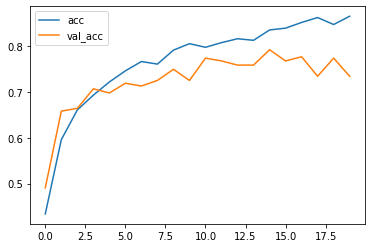

In [18]:
plt.plot(history.history['categorical_accuracy'], label='acc')
plt.plot(history.history['val_categorical_accuracy'], label='val_acc')
plt.legend()
plt.show()

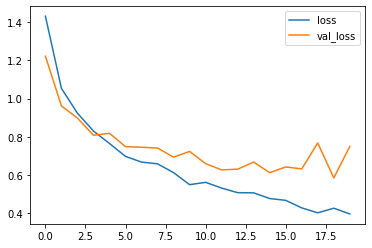

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Model Evaluation

In [22]:
filenames = img_gen_test.filenames

nb_samples = len(filenames)
model.evaluate_generator(img_gen_test, nb_samples)

<ipython-input-22-72e44accbc19>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(img_gen_test, nb_samples)


[0.6901726722717285, 0.7285382747650146]

In [24]:
# Generating predictions on test data

test_x, test_y = img_gen_test.__getitem__(1)
preds = model.predict(test_x)

1/1 [==============================] - 0s 174ms/step


In [25]:
model.evaluate_generator(img_gen_test)

<ipython-input-25-6d3b1f5ffe83>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(img_gen_test)


[0.6901726722717285, 0.7285382747650146]

14/14 [==============================] - 3s 216ms/step
Confusion Matrix


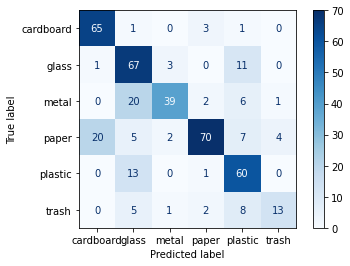

In [26]:
# Confusion Matrix

y_pred = model.predict(img_gen_test)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(img_gen_test.classes, y_pred)
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()



In [28]:
# Accuracy
acc = accuracy_score(img_gen_test.classes, y_pred)
print("Accuracy is {} percent".format(round(acc*100,2)))

Accuracy is 72.85 percent


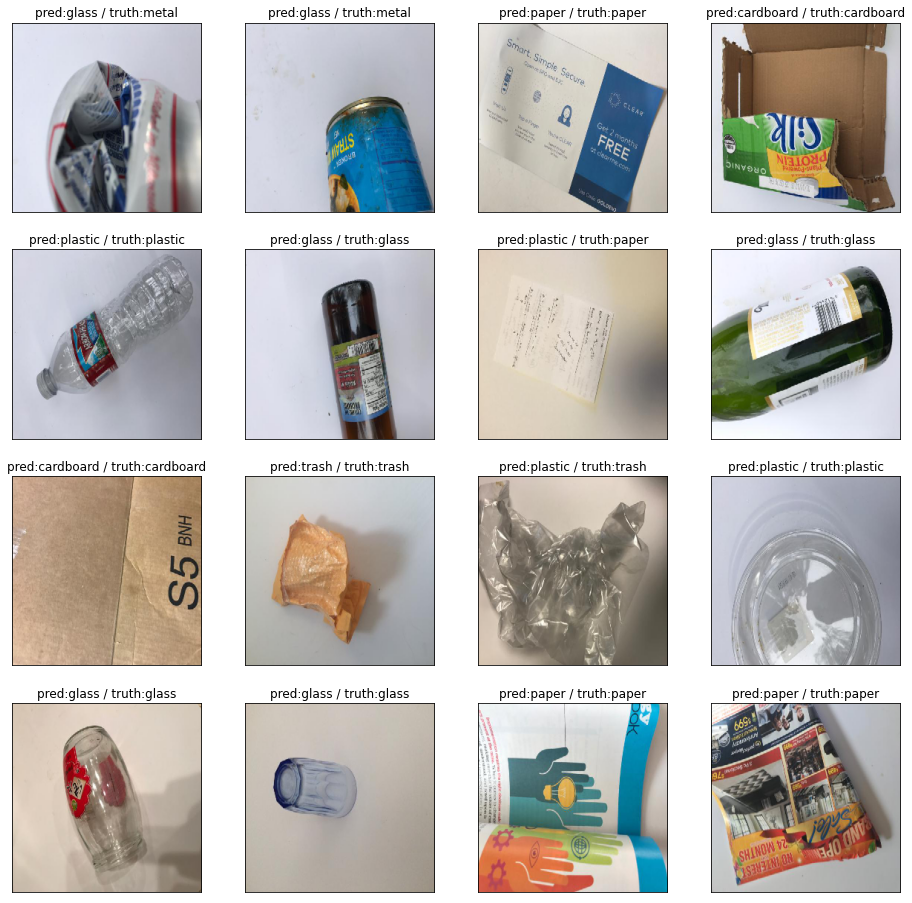

In [29]:
# Comparing predcitons with original labels

labels = (img_gen_train.class_indices)
labels = dict((v,k) for k,v in labels.items())
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])